# The Ultimate Algo Trader (Neurobot 1.0)

## Introduction:
This jupyter notebook contains code for developing and testing a dynamic algorithmic trader based on Python and Machine learning strategy.

## Steps:
1. **Data preperation**: Access historical market data via Alpaca API and preprocess it for analysis.
2. **Strategy creation**: Code algorithmic trading strategy based on "TBD".
3. **Backtesting-Optimization**: Backtest the strategy using historical data and fine-tune parameters for better performance.
4. **Risk/Reward**: Calculate both the risk and the reward based on the entry price, position size, stop-loss and target price
5. **live Trading(Optional)**: Implement the strategy for paper trading on Alpaca.

**Tools and Libaries** 
- Python, Pandas, Numpy, "TBD"

#### Notes: 
- This notebook is for educational and experimental purposes only.

### Imports and Dependencies

In [6]:
import os
import numpy as np
import random
import seaborn as sns
import pandas as pd
import yfinance as yf
import hvplot.pandas
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
from dotenv import load_dotenv
from scipy.interpolate import interp1d
from alpaca_trade_api.rest import REST, TimeFrame

# Initialize python files to import functions
import stock_data as data
import algo_strategy as strategy
import nn_models as model
import backtesting as backtest

import warnings
warnings.filterwarnings('ignore')


In [7]:
load_dotenv()

True

### Data Processing and collection

In [8]:
# Fetch list of tickers
# Get select top picks based on monthly highest performing stocks in sp500 
#ticker_list = data.get_clusters_from_sp500(sp500_url = os.getenv("SP500_URL"))

# fetch_stock_data based on top picks from cluster
stock_data = data.fetch_stock_data('2018-01-12', '2024-03-14', tickers= ['NVDA'], timeframe='1Day')

In [9]:
# data cleaning
stock_df = stock_data #.rename(columns={'NVDA': 'NVDA close'})
stock_df['Daily Returns'] = stock_df['NVDA']['close'].pct_change()
stock_df = stock_df.dropna()
stock_df

NVDA                            Daily Returns
               open   close    high     volume              
timestamp                                                   
2018-01-16  224.050  220.11  227.51   17986928     -0.011892
2018-01-17  220.700  224.72  225.12   13942387      0.020944
2018-01-18  223.940  224.44  226.64   10756754     -0.001246
2018-01-19  228.090  230.11  231.09   15935244      0.025263
2018-01-22  230.430  233.69  233.76   14260753      0.015558
...             ...     ...     ...        ...           ...
2024-03-08  951.379  875.28  974.00  113705642     -0.055477
2024-03-11  864.290  857.74  887.97   67836412     -0.020039
2024-03-12  880.490  919.13  919.60   66807515      0.071572
2024-03-13  910.550  908.88  915.04   63571289     -0.011152
2024-03-14  895.770  879.44  906.46   60231816     -0.032392

[1551 rows x 5 columns]

#### Feauture Engineering - Time series Analysis

In [10]:
stock_df['Cumulative Returns'] = (1 + stock_df['Daily Returns']).cumprod()

In [11]:
stock_df['Daily Returns Lagged'] = stock_df['Daily Returns'].shift(-1)

In [13]:
# set window sizes based on strategy
short_window = 5
long_window = 100

stock_df['SMA_Fast'] = stock_df['NVDA']['close'].rolling(window=short_window).mean()
stock_df['SMA_Slow'] = stock_df['NVDA']['close'].rolling(window=long_window).mean()

stock_df = stock_df.dropna()
stock_df

# later on -> trial different training windows using DateOffset()

NVDA                              Daily Returns  \
               open   close      high     volume                 
timestamp                                                        
2018-06-07  265.000  262.90  265.4785    9818162     -0.008486   
2018-06-08  259.960  262.28  264.0000    9772067     -0.002358   
2018-06-11  261.770  260.62  263.4500    7128668     -0.006329   
2018-06-12  261.690  262.58  263.0700    8509752      0.007521   
2018-06-13  262.640  262.40  265.6700    8951757     -0.000686   
...             ...     ...       ...        ...           ...   
2024-03-07  901.580  926.69  927.6700   60811916      0.044746   
2024-03-08  951.379  875.28  974.0000  113705642     -0.055477   
2024-03-11  864.290  857.74  887.9700   67836412     -0.020039   
2024-03-12  880.490  919.13  919.6000   66807515      0.071572   
2024-03-13  910.550  908.88  915.0400   63571289     -0.011152   

           Cumulative Returns Daily Returns Lagged SMA_Fast  SMA_Slow  
                                                                       
timestamp                                                              
2018-06-07           1.180199            -0.002358  263.118  238.5978  
2018-06-08           1.177416            -0.006329  264.050  239.0195  
2018-06-11           1.169964             0.007521  263.204  239.3785  
2018-06-12           1.178763            -0.000686  262.706  239.7599  
2018-06-13           1.177955             0.017188  262.156  240.0828  
...                       ...                  ...      ...       ...  
2024-03-07           4.160056            -0.055477  869.698  557.9234  
2024-03-08           3.929269            -0.020039  880.196  562.1301  
2024-03-11           3.850529             0.071572  881.270  566.0980  
2024-03-12           4.126118            -0.011152  893.168  570.8955  
2024-03-13           4.080105            -0.032392  897.544  575.7647  

[1451 rows x 9 columns]

### Algo trading strategies (Simple winning and Hybrid trading) returns buy or sell signal

In [14]:
# Initialize Signals 
signals = {"signal_one": strategy.strategy_one(stock_data),
           "signal_two": strategy.strategy_two(stock_data),
           "signal_three": strategy.strategy_three(stock_data),
           "signal_four": strategy.strategy_four(stock_data),
           "signal_five": strategy.strategy_five(stock_data)}

# Initialize a simple winnig trading strategy 
def simple_winning_strategies(stock_data):
    
    best_strategy = max(signals,key=signals.get)
    winning_signal = signals[best_strategy]
        
    return winning_signal
    
# Initialize a strategy that uses historical stock data and returns a hybrid trading strategy (Majority vote)   
def hybrid_strategies(Stock_data):
    
    buy_signal = sum(1 for signal in signals.values() if signal == 1)    # "Buy"
    sell_signal = sum(1 for signal in signals.values() if signal == -1)  # "Sell"
    
    hybrid_signal = 0 # "Hold"
    
    if buy_signal > sell_signal:
        hybrid_signal = 1 # "Buy"
    elif sell_signal > buy_signal:
        hybrid_signal = -1 # "Sell"  
        
    return hybrid_signal

# Add signals to stock_df
stock_df['Hybrid_signal'] = hybrid_strategies(stock_data)

stock_df['Winning_signal'] = simple_winning_strategies(stock_data)

# plot winnig signal and hybrid

### Machine Learning (LSTM ) + other model logreg or SVM - Logic that compares which model 

### Backtesting - Model and strategy tuning logic to increased Returns

### Risk management and Rewards

### Fundamental Analysis (Predictions and Plotting)

In [12]:
stock_df[['Daily Returns Lagged', 'Daily Returns']].corr()

# maybe not to use lagged strategy 
# consider DMAC? 

,,Daily Returns Lagged,Daily Returns
,,,
Daily Returns Lagged,,1.000000,-0.080654
Daily Returns,,-0.080654,1.000000


<Axes: xlabel='timestamp'>

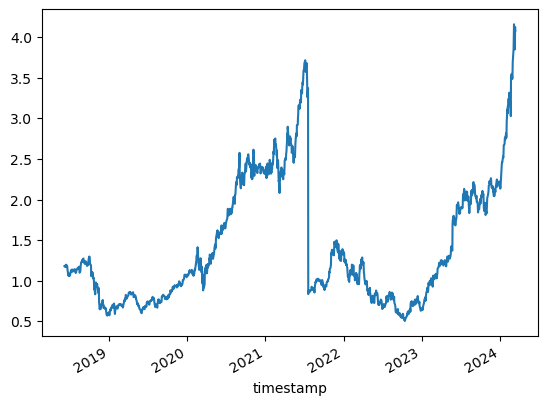

In [15]:
stock_df['Cumulative Returns'].plot()

### Logic to place trade (Optional)

In [ ]:
# From Algo Trading 3 live 

# Submit order
api.submit_order(
    symbol="META", 
    qty=number_of_shares, 
    side=orderSide, 
    time_in_force="gtc", 
    type="limit", 
    limit_price=limit_amount
